# Problem Description

You are provided a dataset of medical insurance records in the file `./data/insurance.csv` (original source: https://www.kaggle.com/datasets/mirichoi0218/insurance).

Your goal is to design a neural network with Keras to predict the medical costs billed by health insurance for each individual, given their personal characteristics.

# 1. Import the required libraries

Let's start by importing a bunch of libraries that will be needed in the rest of the notebook:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/insurance


Next, set the seed both for numpy and for Keras. This should ensure reproducibility of the results. Please, **do not change the seed** for the exam delivery:

In [3]:
seed=1
np.random.seed(seed)
keras.utils.set_random_seed(seed)

# 2. Read and analyze the dataset

Read the dataset using pandas:

In [4]:
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')

Display the first few lines of the dataset to see its structure:

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Here's a description of the features:
- `age`: age of primary beneficiary
- `sex`: insurance contractor gender (female, male)
- `bmi`: body mass index (kg / m ^ 2)
- `children`: number of children covered by health insurance / number of dependents
- `smoker`: primary beneficiary is a smoker (yes, no)
- `region`: the beneficiary's residential area in the US (northeast, southeast, southwest, northwest)
- `charges` **[target]**: individual medical costs billed by health insurance


As you can see, we have both numerical and categorical data. The `charges` column of each row is what we want to predict. It's a numerical variable in dollars. Let's see how many samples we have:

In [6]:
print('Number of samples: ', df.shape[0])
print('Number of features: ', df.shape[1])

Number of samples:  1338
Number of features:  7


Optionally, add more cells here to explore the dataset if you think they are useful:

# **ESPLORAZIONE DEI DATI (EDA)**

Nelle celle seguenti vedremo quali sono i valori unici nelle feature categoriche, il min e max per le feature numeriche e, successivamente, vedremo come i dati sono distribuiti, in modo da capire se ci sia del lavoro da fare su eventuali outliar e se possiamo già aspettarci qualcosa solo guardando ai dati.

Come possiamo vedere di seguito nel dataset non sono presenti valori nulli (o nan), ed in generale non vi sono elementi che sporcano il nostro dataset ( come ad esempio errori di battitura es: 'fenale' al posto di 'female') e le variabili numeriche non presentano elementi irrealistici (come ad esempio un 'bmi' pari a 0).

In [7]:
print('Number of null values for each column')
print(df.isnull().sum(),'\n')

print('Minimum age: ', df['age'].min())
print('Maximum age: ', df['age'].max(),'\n')

print('Element in sex column: ', df['sex'].unique().tolist(),'\n')

print('Minimum bmi: ', df['bmi'].min())
print('Maximum bmi: ', df['bmi'].max(),'\n')

print('Minimum children: ', df['children'].min())
print('Maximum children: ', df['children'].max(),'\n')

print('Element in smoker column: ', df['smoker'].unique().tolist(),'\n')

print('Element in region column: ', df['region'].unique().tolist(),'\n')

print('Minimum charge: ', df['charges'].min())
print('Maximum charge: ', df['charges'].max(),'\n')

Number of null values for each column
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64 

Minimum age:  18
Maximum age:  64 

Element in sex column:  ['female', 'male'] 

Minimum bmi:  15.96
Maximum bmi:  53.13 

Minimum children:  0
Maximum children:  5 

Element in smoker column:  ['yes', 'no'] 

Element in region column:  ['southwest', 'southeast', 'northwest', 'northeast'] 

Minimum charge:  1121.8739
Maximum charge:  63770.42801 



Possiamo ora vedere quante persone abbiamo per ogni feature categorica. Quello che si può osservare è che la regione del sud-est è quella che presenta il maggior numero di persone nel dataset, anche se di poco. La maggior parte delle persone è non fumatrice, il numero di uomini e donne è pressochè identico ed infine, come ci si può aspettare il rapporto tra numero di bambini e quantità di persone è inversamente proporzionale.

In [8]:
print(df['region'].value_counts(),'\n')
print(df['smoker'].value_counts(),'\n')
print(df['sex'].value_counts(),'\n')
print(df['children'].value_counts())

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64 

smoker
no     1064
yes     274
Name: count, dtype: int64 

sex
male      676
female    662
Name: count, dtype: int64 

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64


Guardiamo ora la distribuzione delle variabili numeriche age, bmi e charges.

Quello che possiamo vedere è che mentre bmi sembra gaussiana, age e charges non lo sono, ma possono essere approssimati, in quanto resembranti.

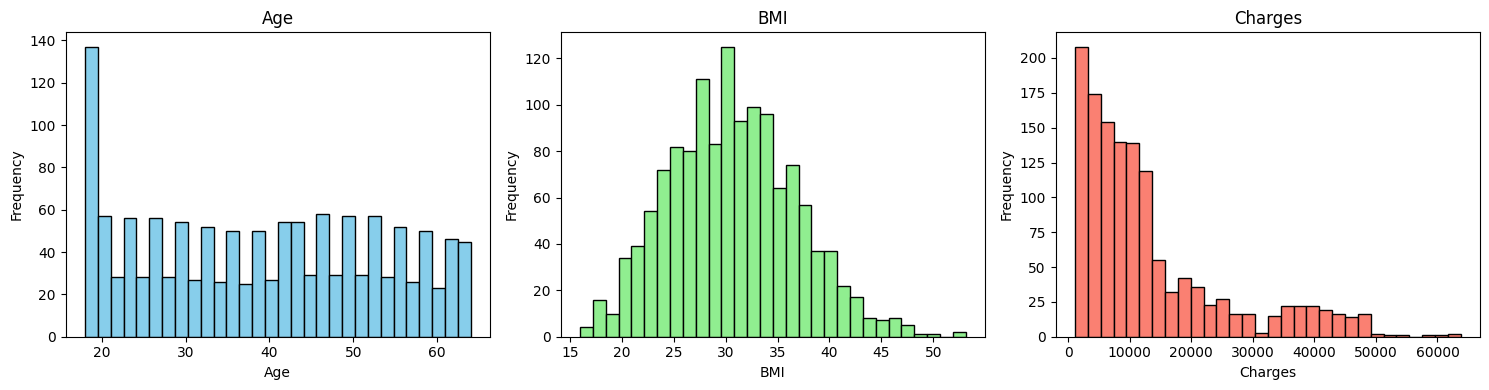

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 cols

# Histogram for 'age'
axes[0].hist(df['age'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Histogram for 'bmi'
axes[1].hist(df['bmi'], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('BMI')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Frequency')

# Histogram for 'charges'
axes[2].hist(df['charges'], bins=30, color='salmon', edgecolor='black')
axes[2].set_title('Charges')
axes[2].set_xlabel('Charges')
axes[2].set_ylabel('Frequency')

plt.tight_layout()  # adjusts spacing to prevent overlap
plt.show()

Guardando ora i countplot "multivariati", possiamo osservare che vi è omogeneità per le varie classi nella distribuzione del numero di figli ad eccenzione della regione del sud-est, dove le persone assicurate con 5 figli sono più di quelle con 4 figli.

In [10]:
num_col = ['age', 'bmi', 'charges']

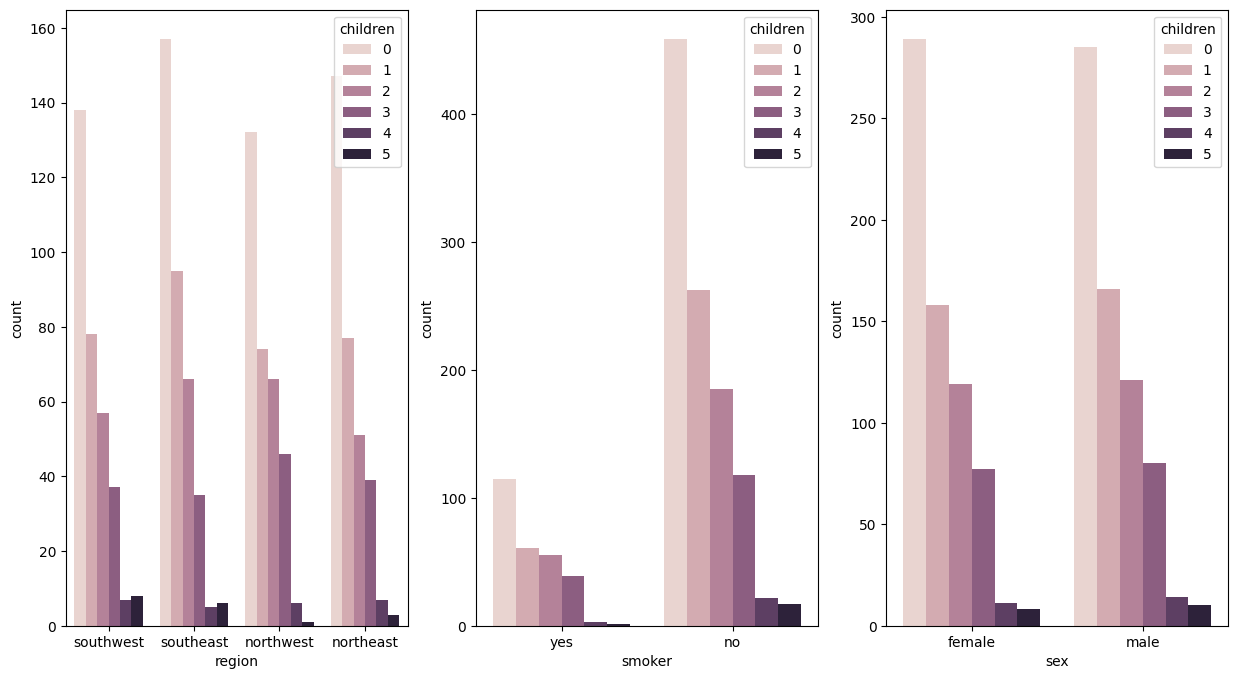

In [11]:
interesting_columns = ['region', 'smoker', 'sex']

fig, ax = plt.subplots(ncols=len(interesting_columns), nrows=1, figsize=(15, 8))
index = 0
ax = ax.flatten()
for col in interesting_columns:
    sns.countplot(x=col, hue="children", data=df, ax=ax[index])
    index += 1

Dai prossimi 3 gruppi di grafici, dove si mette in evidenza una differente variabile categorica, invece non si riesce a trovare alcun pattern interessante.

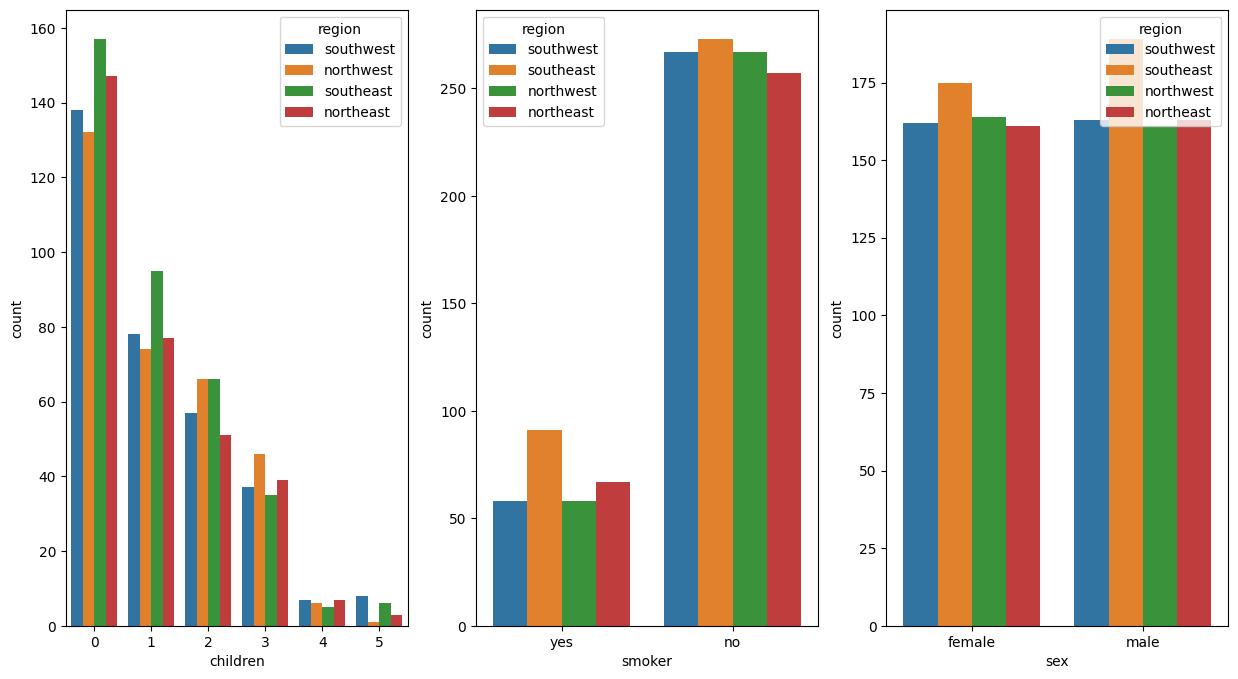

In [12]:
interesting_columns = ['children', 'smoker', 'sex']

fig, ax = plt.subplots(ncols=len(interesting_columns), nrows=1, figsize=(15, 8))
index = 0
ax = ax.flatten()
for col in interesting_columns:
    sns.countplot(x=col, hue="region", data=df, ax=ax[index])
    index += 1

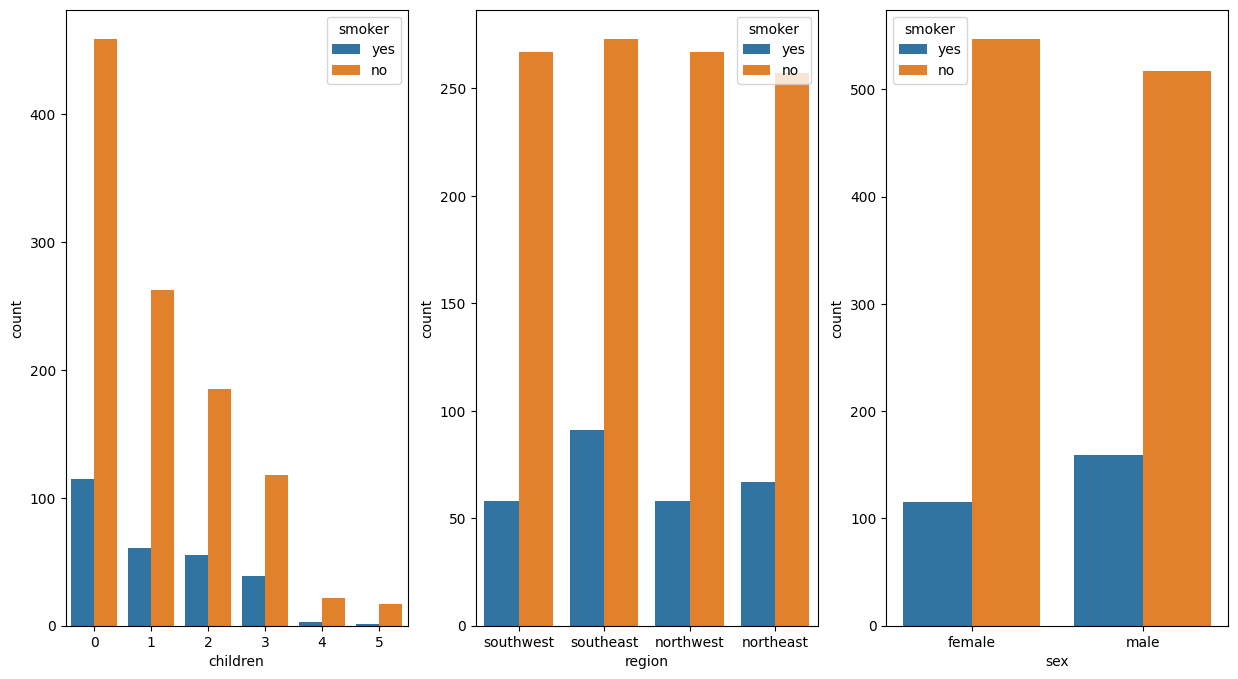

In [13]:
interesting_columns = ['children', 'region', 'sex']

fig, ax = plt.subplots(ncols=len(interesting_columns), nrows=1, figsize=(15, 8))
index = 0
ax = ax.flatten()
for col in interesting_columns:
    sns.countplot(x=col, hue="smoker", data=df, ax=ax[index])
    index += 1

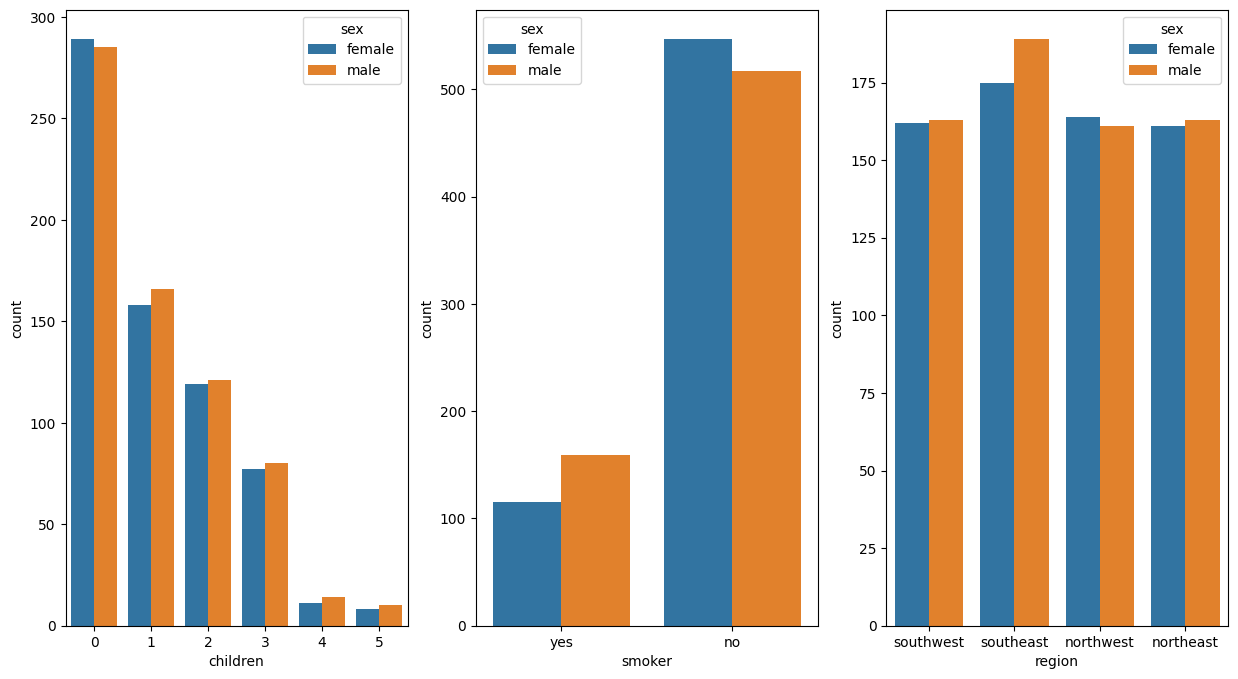

In [14]:
interesting_columns = ['children', 'smoker', 'region']

fig, ax = plt.subplots(ncols=len(interesting_columns), nrows=1, figsize=(15, 8))
index = 0
ax = ax.flatten()
for col in interesting_columns:
    sns.countplot(x=col, hue="sex", data=df, ax=ax[index])
    index += 1

Ora vediamo i boxplot di ogni feature numerica mettendo sempre in evidenza una variabile categorica.

Rispetto ai fumatori, come ci si può immaginare, mentre non si hanno differenze rispetto ad età e bmi, si può subito osservare che il valore "charges" diminuisce notevolmente per i non fumatori (come ci si può aspettare).

Notiamo però, nella feature 'bmi' dei possibili outliers per bmi superiori a 50.

<Axes: xlabel='smoker', ylabel='charges'>

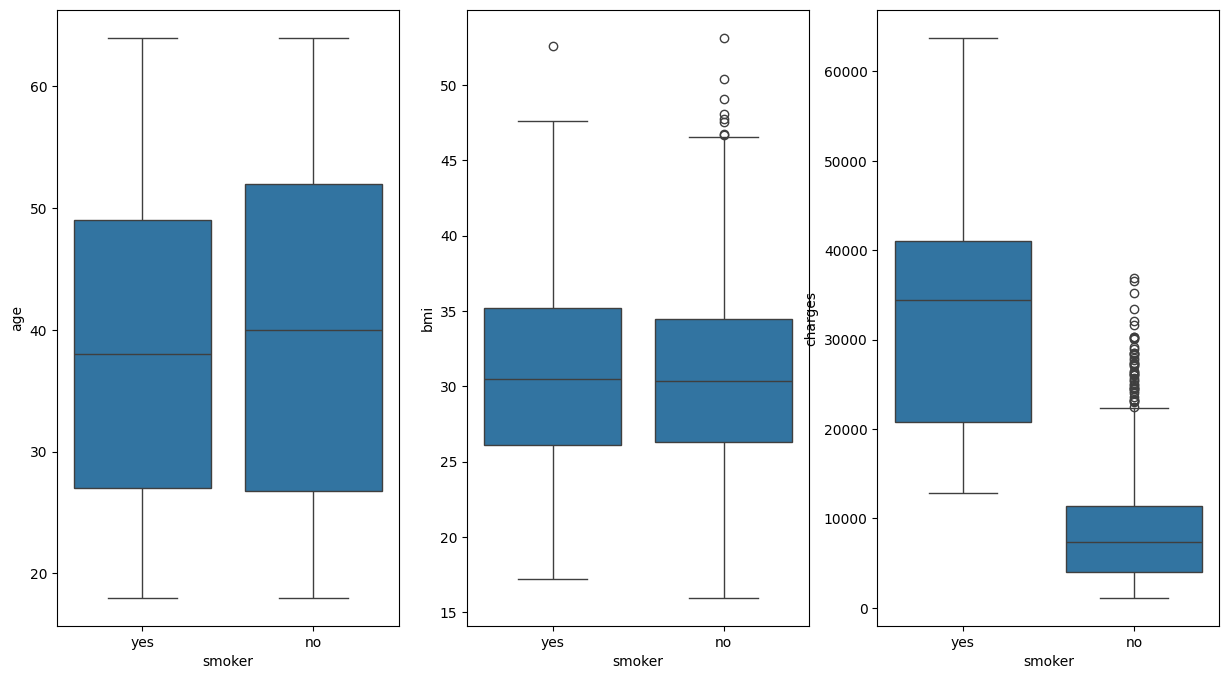

In [15]:
fig, axes = plt.subplots(nrows = 1, ncols= 3, figsize = (15,8))
main_col = 'smoker'

sns.boxplot(x = main_col, y = df[num_col[0]],data = df, ax =axes[0])
sns.boxplot(x = main_col, y = df[num_col[1]],data = df, ax= axes[1])
sns.boxplot(x = main_col, y = df[num_col[2]],data = df, ax= axes[2])

Mentre si può dire che nel dataset preso in considerazione, gli uomini tendono ad avere un bmi leggeremente maggiore rispetto alle donne e conseguentemente una distribuzione di "charges" leggermente superiore.

Nuovamente possiamo vedere in 'bmi' dei valori superiori a 50 e che rafforzano l'ipotesi di outliers. Inoltre, possiamo osservare in charges che alcuni valori vicini a 60000 possono anch'essi essere outliers.

<Axes: xlabel='sex', ylabel='charges'>

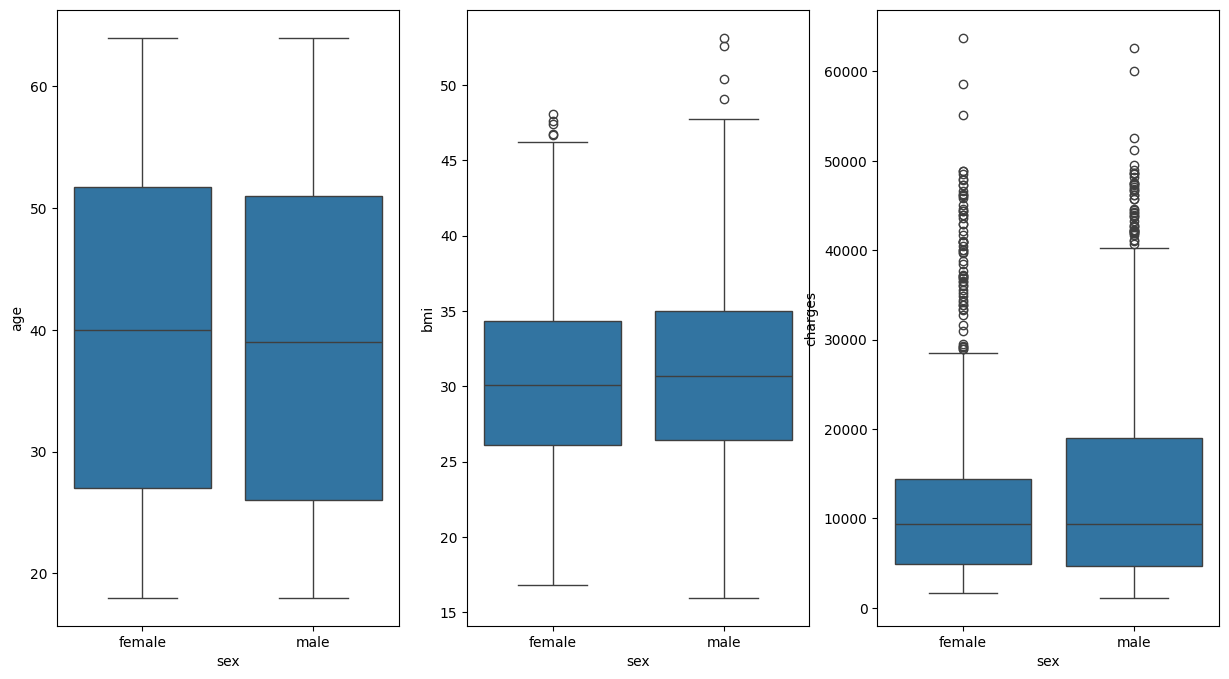

In [16]:
fig, axes = plt.subplots(nrows = 1, ncols= 3, figsize = (15,8))
main_col = 'sex'

sns.boxplot(x = main_col, y = df[num_col[0]],data = df, ax =axes[0])
sns.boxplot(x = main_col, y = df[num_col[1]],data = df, ax= axes[1])
sns.boxplot(x = main_col, y = df[num_col[2]],data = df, ax= axes[2])

Vedendo ora rispetto al numero dei bambini, si può osservare che coloro che hanno 4/5 figli tendono ad essere mediamente più giovani e con "charges" nettamente inferiori (in distribuzione) nonostante la media sia vicina a quella delle altre categorie. Ciò però può essere dovuto alla scarsità del campione. Infatti, rispetto alle altre categorie, le quali contano almeno 150 persone, quelle con 4 e 5 figli combinate contano appena 43 persone.

Rispetto agli outlier, a questo punto possiamo essere abbastanza sicuri che dei valori in 'bmi' possono esser considerati outliers, mentre si rafforza l'ipotesi per quelli in charges.

<Axes: xlabel='children', ylabel='charges'>

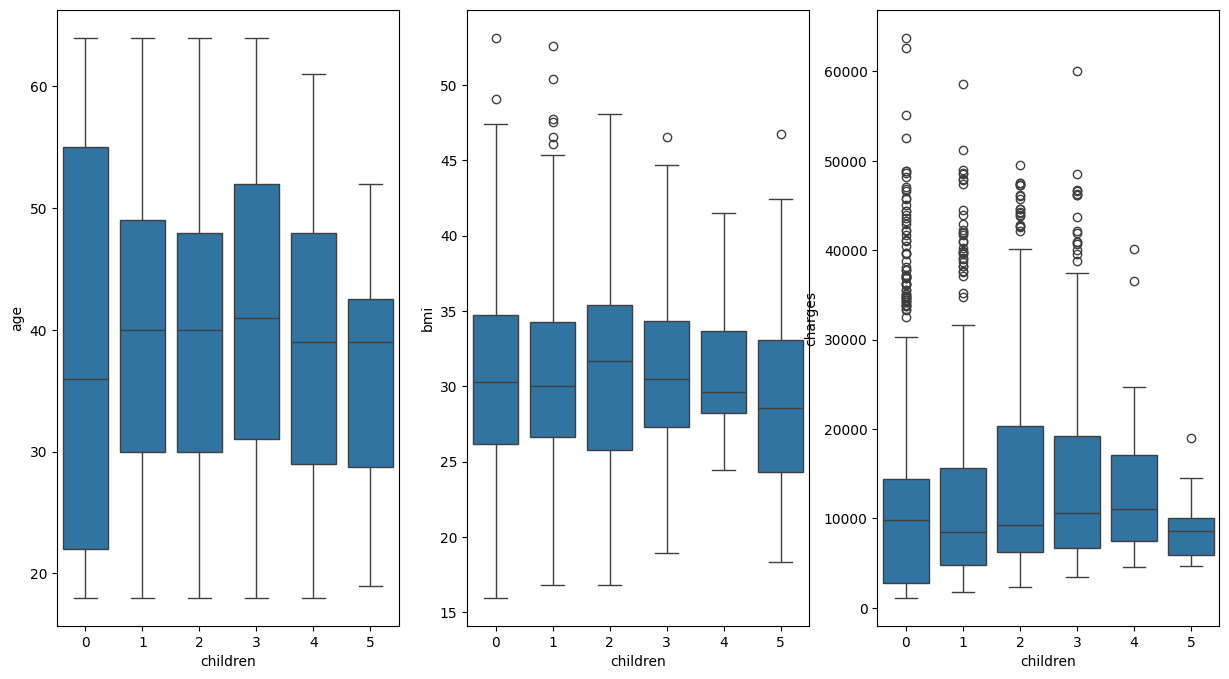

In [17]:
fig, axes = plt.subplots(nrows = 1, ncols= 3, figsize = (15,8))
main_col = 'children'

sns.boxplot(x = main_col, y = df[num_col[0]],data = df, ax =axes[0])
sns.boxplot(x = main_col, y = df[num_col[1]],data = df, ax= axes[1])
sns.boxplot(x = main_col, y = df[num_col[2]],data = df, ax= axes[2])

Infine, guardano le distribuzioni per regione, possiamo osservare come non vi siano grandi differenze tra le 4 zone prese in considerazione.

Quello che però ora è sicuro è la presenza di outliers nelle feature 'bmi' e 'charges', in particolare i valori vicini a 50 e 60000.

<Axes: xlabel='region', ylabel='charges'>

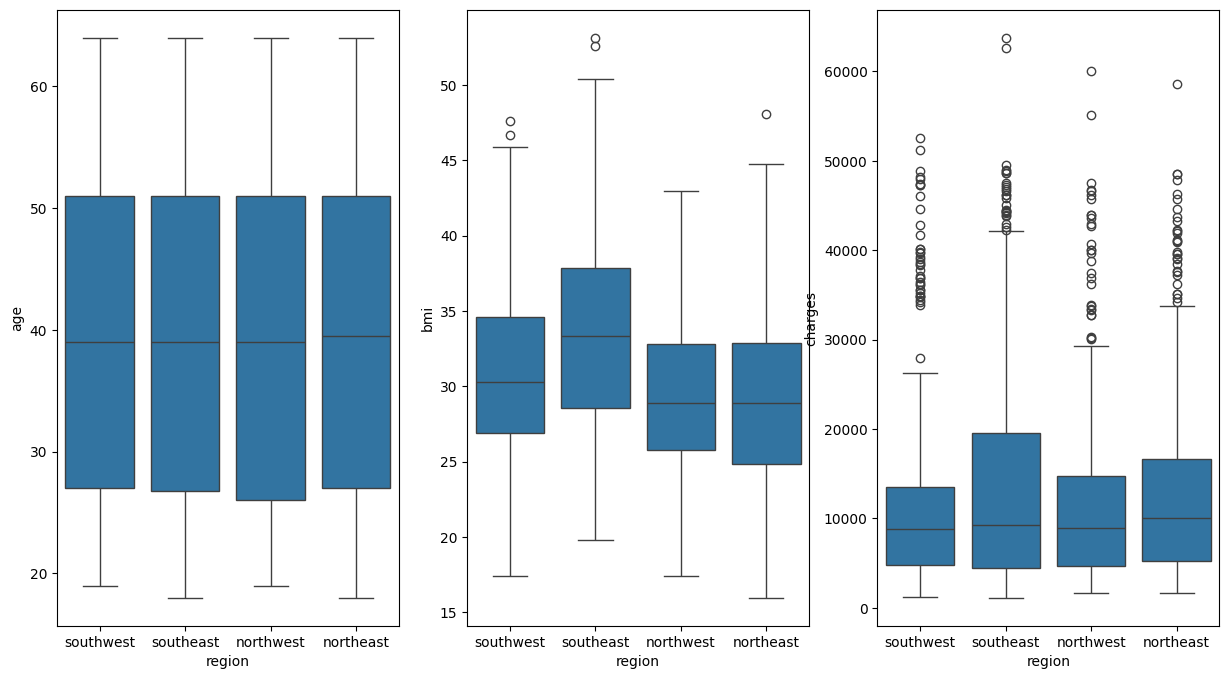

In [18]:
fig, axes = plt.subplots(nrows = 1, ncols= 3, figsize = (15,8))
main_col = 'region'

sns.boxplot(x = main_col, y = df[num_col[0]],data = df, ax =axes[0])
sns.boxplot(x = main_col, y = df[num_col[1]],data = df, ax= axes[1])
sns.boxplot(x = main_col, y = df[num_col[2]],data = df, ax= axes[2])

Visti i boxplot decido di eliminare i dati che presentano un indice 'bmi'>50 e quelli che hanno 'charges'>50000.

In [19]:
print(df[df['bmi'] > 50])
#df = df[df['bmi'] <= 50]
df[df['bmi'] > 50]

      age   sex    bmi  children smoker     region     charges
847    23  male  50.38         1     no  southeast   2438.0552
1047   22  male  52.58         1    yes  southeast  44501.3982
1317   18  male  53.13         0     no  southeast   1163.4627


,age,sex,bmi,children,smoker,region,charges
847,23,male,50.38,1,no,southeast,2438.0552
1047,22,male,52.58,1,yes,southeast,44501.3982
1317,18,male,53.13,0,no,southeast,1163.4627


In [20]:
#print(df[df['charges'] > 50000])
#df = df[df['charges'] <= 50000]

Ora, per concludere, vediamo i plot dei dati numerici a confronto tra loro differenziando per colore le feature categoriche.

Ora, analizzando i grafici ed ignorando i colori, possiamo osservare che la distribuzione congiunta (bmi, age) è quasi uniforme, e non è possibile estrarre alcun pattern. Ma, guardando a (age, charges), possiamo osservare 3 chiari cluster che al momento non siamo propriamente in grado di spiegare. Mentre (bmi, charges) ha una distribuzione più chiara, infatti sembra che tutta la "massa" si possa trovare sotto la curva simil logaritmica che cresce linearmente per arrivare ad appiattirsi intorno ai 45000.

Rispetto ai colori, ed in questo caso alle regioni, è chiaro che non possiamo estrarre alcuna informazione.

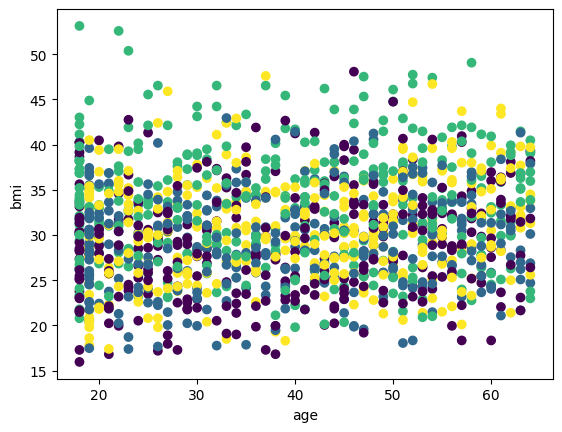

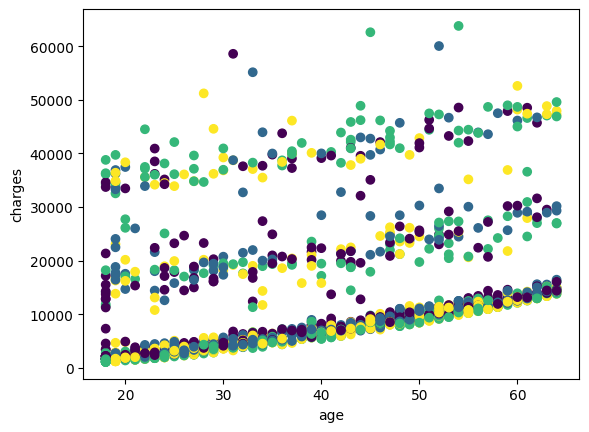

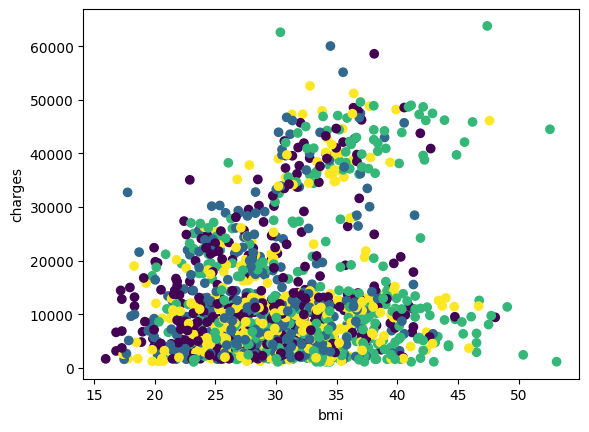

In [21]:
color1 = df.loc[:, "region"].map(dict({"southwest": 3, "southeast": 2, "northwest": 1, "northeast":0 })).tolist()

x1 = df.loc[:, "age"]
y1 = df.loc[:,"bmi"]
plt.scatter(x1,y1, c = color1)
plt.xlabel("age")
plt.ylabel("bmi")
plt.show()

x2 = df.loc[:, "age"]
y2 = df.loc[:,"charges"]
plt.scatter(x2,y2, c = color1)
plt.xlabel("age")
plt.ylabel("charges")
plt.show()

x3 = df.loc[:, "bmi"]
y3 = df.loc[:,"charges"]
plt.scatter(x3,y3, c = color1)
plt.xlabel("bmi")
plt.ylabel("charges")
plt.show()

Differenziando rispetto al "fuma" o "non fuma" invece, mentre il primo plot rimane "randomico", nel secondo si può chiaramente vedere una prima distinzione in cluster, infatti coloro che fumano si trovano nel cluster superiore, mentre i non fumatori in quello inferiore. Nel centro rimane invece una zona franca. Infine nel terzo plot (mbi, charges) possiamo vedere chiaramente che i fumatori, indipendentemente dal bmi, sostengono costi maggiori.

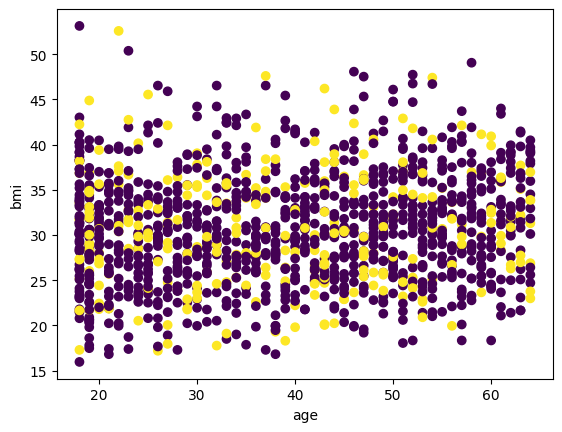

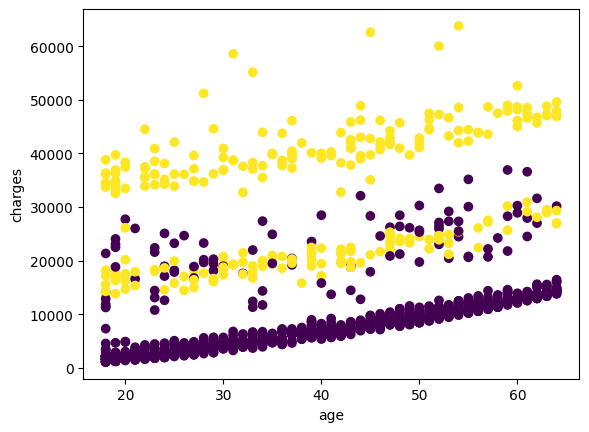

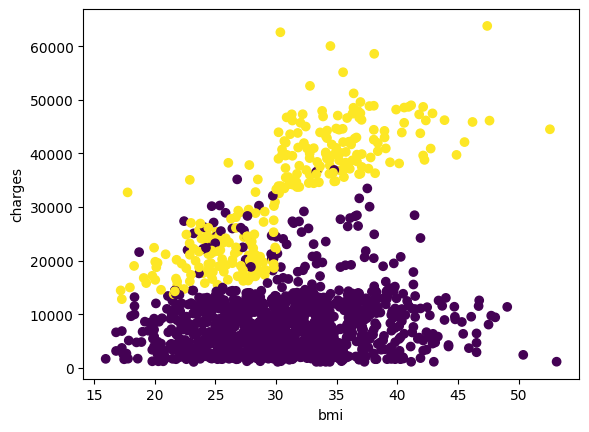

In [22]:
color2 = df.loc[:, "smoker"].map(dict({"yes": 1, "no": 0})).tolist()

x1 = df.loc[:, "age"]
y1 = df.loc[:,"bmi"]
plt.scatter(x1,y1, c = color2)
plt.xlabel("age")
plt.ylabel("bmi")
plt.show()

x2 = df.loc[:, "age"]
y2 = df.loc[:,"charges"]
plt.scatter(x2,y2, c = color2)
plt.xlabel("age")
plt.ylabel("charges")
plt.show()

x3 = df.loc[:, "bmi"]
y3 = df.loc[:,"charges"]
plt.scatter(x3,y3, c = color2)
plt.xlabel("bmi")
plt.ylabel("charges")
plt.show()

Guardando invece al sesso, come ci si può aspettare, non si riesce a riscontrare alcun patttern.

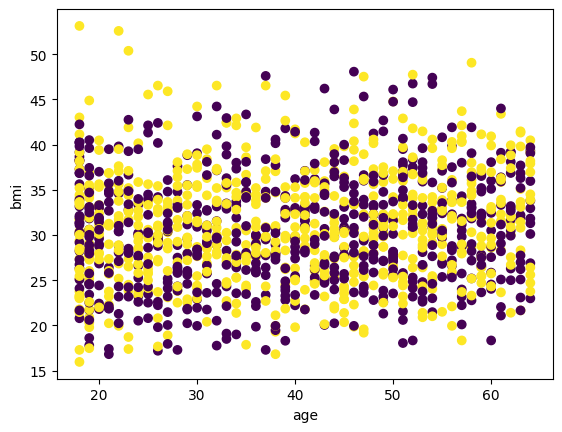

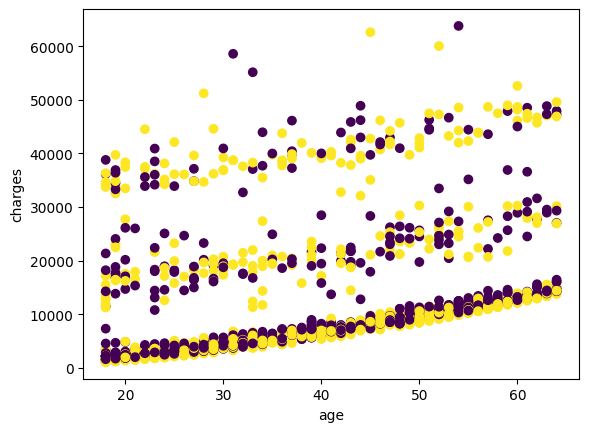

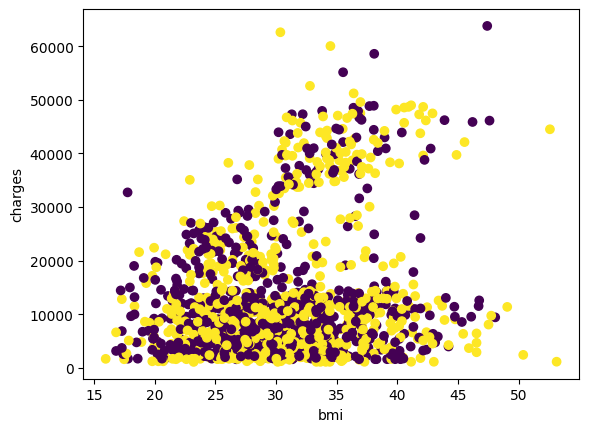

In [23]:
color3 = df.loc[:, "sex"].map(dict({"male": 1, "female":0 })).tolist()

x1 = df.loc[:, "age"]
y1 = df.loc[:,"bmi"]
plt.scatter(x1,y1, c = color3)
plt.xlabel("age")
plt.ylabel("bmi")
plt.show()

x2 = df.loc[:, "age"]
y2 = df.loc[:,"charges"]
plt.scatter(x2,y2, c = color3)
plt.xlabel("age")
plt.ylabel("charges")
plt.show()

x3 = df.loc[:, "bmi"]
y3 = df.loc[:,"charges"]
plt.scatter(x3,y3, c = color3)
plt.xlabel("bmi")
plt.ylabel("charges")
plt.show()

Infine, vedendo il numero di figli, non si riesce a riscontrare alcun patttern.

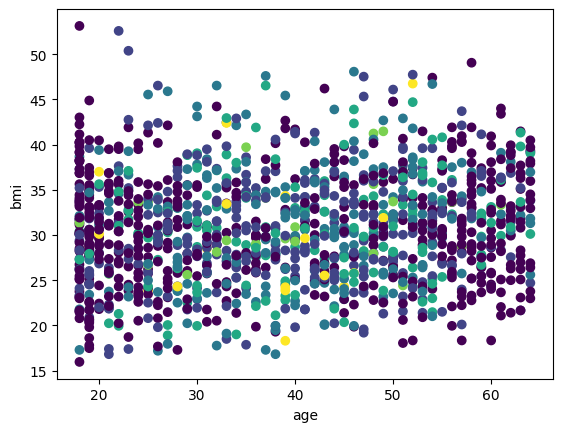

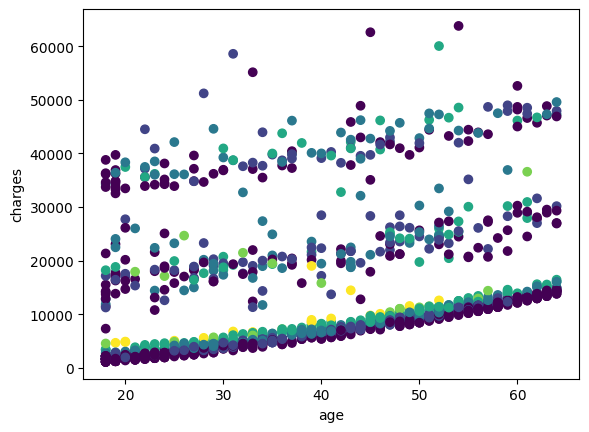

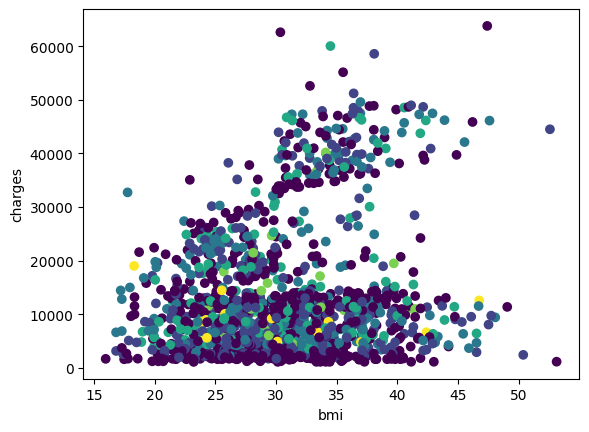

In [24]:
color4 = df.loc[:, "children"].map(dict({5:5,4:4,3: 3, 2: 2, 1: 1, 0:0 })).tolist()

x1 = df.loc[:, "age"]
y1 = df.loc[:,"bmi"]
plt.scatter(x1,y1, c = color4)
plt.xlabel("age")
plt.ylabel("bmi")
plt.show()

x2 = df.loc[:, "age"]
y2 = df.loc[:,"charges"]
plt.scatter(x2,y2, c = color4)
plt.xlabel("age")
plt.ylabel("charges")
plt.show()

x3 = df.loc[:, "bmi"]
y3 = df.loc[:,"charges"]
plt.scatter(x3,y3, c = color4)
plt.xlabel("bmi")
plt.ylabel("charges")
plt.show()

Prima di passare al preprocessing, dato che abbiamo visto estitere una struttura nei dati, si può fare un plot 3d per fare un'ultima prova di interpretazione. Dove coloro di giallo i fumatori e viola i non fumatori.

In [25]:
import plotly.graph_objects as go

In [26]:
fig = go.Figure(data=[go.Scatter3d(
    x=df.loc[:, "age"],
    y=df.loc[:, "bmi"],
    z=df.loc[:, "charges"],
    mode='markers',
    marker=dict(
        size=8,
        color=color2)
    )])
fig.update_layout(
    scene=dict(
        xaxis_title='age',
        yaxis_title='bmi',
        zaxis_title='charges'
    )
)
fig.show()

Non molto è possibile estrarre, oltre quello che già sappiamo. Per cui, si passa al preprocessing.

# 3. Data pre-processing

## Normalization of numerical features

Normalizing numerical features is very important for training. In this case, it's quite important to also normalize the target (i.e., the `charges` column), because as you can verify, it contains very large values, that could create numerical problems during training. Therefore, we do normalization *before* splitting inputs and outputs.

Start by selecting  the numerical features:

Ora, prima di continuare decido, per la feature children, di incorporare le classi 3, 4, 5 in 3+. Questo perché 4 e 5 da sole contano appeno 40 elementi, per cui, data anche la rarità dell'evento 3 figli, decido di accorpare tutti e 3. Raggiungendo una classe con circa 150 elementi (2 figli sono 200 circa)

In [27]:
df['children'] = df['children'].apply(lambda x: str(x) if x < 3 else '3+')

In [28]:
df_num = df.select_dtypes(include='number')
num_column = df_num.columns
df_num.head()

,age,bmi,charges
0,19,27.900,16884.92400
1,18,33.770,1725.55230
2,28,33.000,4449.46200
3,33,22.705,21984.47061
4,32,28.880,3866.85520


Normalize the numerical columns (in this case, we didn't split into training and validation sets yet, so we don't need to concatenate):

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
#Siccome voglio normalizzare, ricordo i histogrammi iniziali delle 3 feature numeriche, in particolare
#il fatto che bmi è simil gaussiana per cui scelgo di standardizzare.

stdScaler = StandardScaler()
df_num = stdScaler.fit_transform(df_num)

Finally, recombine the numerical columns with the rest of the dataset:

In [31]:
for i in range(len(num_column)):
  df[num_column[i]] = df_num[:,i]
df.head()

,age,sex,bmi,children,smoker,region,charges
0,-1.438764,female,-0.453320,0,yes,southwest,0.298584
1,-1.509965,male,0.509621,1,no,southeast,-0.953689
2,-0.797954,male,0.383307,3+,no,southeast,-0.728675
3,-0.441948,male,-1.305531,0,no,northwest,0.719843
4,-0.513149,male,-0.292556,0,no,northwest,-0.776802


## Encoding of categorical columns as "one-hot"

We should also convert categorical features to "one-hot" representation (sometimes called "dummy variables"):

In [32]:
df = pd.get_dummies(df, drop_first=True)
#df_temp = df.drop(columns = ['sex_female', 'children_3+', 'smoker_no','region_northeast'])
#df_temp['sex_male'] = df_temp['sex_male'].map({True: 1, False: 0})
#df_temp['children_0'] = df_temp['children_0'].map({True: 1, False: 0})
#df_temp['children_1'] = df_temp['children_1'].map({True: 1, False: 0})
#df_temp['children_2'] = df_temp['children_2'].map({True: 1, False: 0})
#df_temp['smoker_yes'] = df_temp['smoker_yes'].map({True: 1, False: 0})
#df_temp['region_southeast'] = df_temp['region_southeast'].map({True: 1, False: 0})
#df_temp['region_southwest'] = df_temp['region_southwest'].map({True: 1, False: 0})
#df_temp['region_northwest'] = df_temp['region_northwest'].map({True: 1, False: 0})
#df_temp.head()

In [33]:
#df = df_temp.copy()
df.head()

,age,bmi,charges,sex_male,children_1,children_2,children_3+,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,0.298584,False,False,False,False,True,False,False,True
1,-1.509965,0.509621,-0.953689,True,True,False,False,False,False,True,False
2,-0.797954,0.383307,-0.728675,True,False,False,True,False,False,True,False
3,-0.441948,-1.305531,0.719843,True,False,False,False,False,True,False,False
4,-0.513149,-0.292556,-0.776802,True,False,False,False,False,True,False,False


Display the new data shape and check how many columns we end up with:

In [34]:
# Display the new numner of rows and columns in the dataframe
df.shape

(1338, 11)

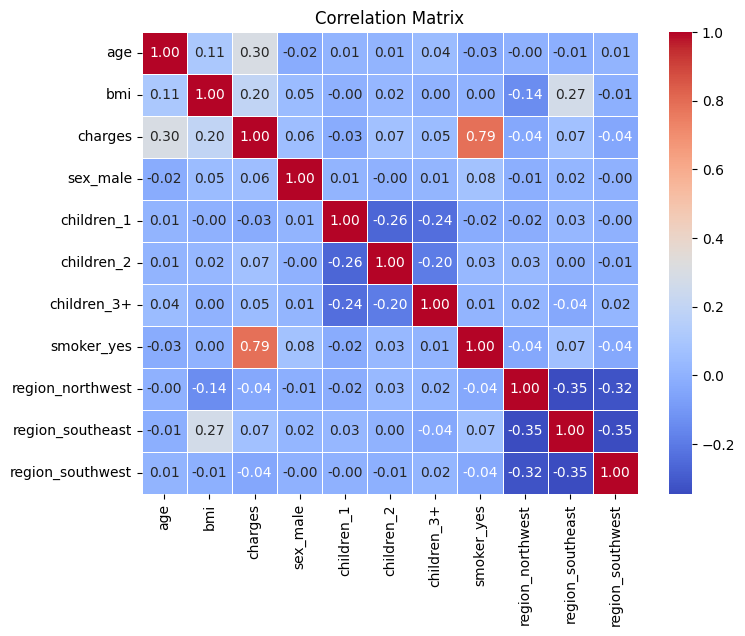

In [35]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Input/output Separation

Separate the target column (y) from the rest of the features (X):


In [36]:
# Separate the target from the rest of the features
X_columns = df.columns.tolist()
X_columns.remove('charges')
X = df.loc[:,X_columns]
Y = df.loc[:,'charges']

## Conversion to Numpy

Keras cannot read directly pandas dataframes. We must convert the X and y data to `numpy` arrays:


In [37]:
# Convert X and y to numpy arrays
X = X.to_numpy().astype('float')
Y = Y.to_numpy().astype('float')

## Training and Validation Set Split

Lastly, we split the data into training and validation sets. For simplicity, we use a *single* data split for this example (no KFold Cross-Validation):


In [38]:
# Split the X and y data into trainining and validation sets using the sklearn train_test_split utility
# Use 20% of the data as validation set, and set the parameter random_state=seed for consistency of results
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=True, random_state = seed)

Display the number of training and validation examples:

In [39]:
# Display the number of training and validation inputs
print('Shape dei dati di training: ',X_train.shape)
print('Shape dei dati di test:     ',X_test.shape)

Shape dei dati di training:  (1070, 10)
Shape dei dati di test:      (268, 10)


# 4. Build a Keras model

Define the neural network used to predict the medical costs. Use a Single- or Multi-Layer Perceptron.
You can freely set the number of layers, the number of neurons/units in each layer, the type of activation function, etc. You can also use the special layers seen during the course to regularize the model and improve generalization.

Just remember the constraints on the output layer: *what kind of problem are we solving?*

The goal is, of course, finding the combination of hyper-parameters that minimizes the validation error!! As your n.1 target metric, focus on the **Mean Absolute Error (MAE)** for this exam:



In [86]:
# Define a neural network to predict the medical insurance costs
# Expected: 5-15 lines
model = keras.Sequential([
    Dense(50, activation='tanh', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dense(1, activation='relu')
])

model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_163 (Dense)               │ (None, 50)             │           550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,801 (42.19 KB)

 Trainable params: 10,801 (42.19 KB)

 Non-trainable params: 0 (0.00 B)

Display a summary of the neural network architecture you just created:

In [87]:
# Display the neural network summary
model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_163 (Dense)               │ (None, 50)             │           550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,801 (42.19 KB)

 Trainable params: 10,801 (42.19 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the model

Associate a training objective (loss function), an optimization method, and some metrics, to your model. Again, you are free to select hyperparameters such as the optimizer, learning rate, etc. But be careful to select the correct loss function and reasonable metrics to monitor:

In [88]:
# Compile the model selecting appropriate loss function and metrics.
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=opt,
    loss='huber',
    metrics=['mae'],
)


## Train the Model

Train the model you have just created. Again, you have some freedom to select hyperparameters such as the number of epochs, the batch size, etc. You can also add callbacks if you want. Use additional code cells for callbacks, if needed:

In [89]:
import time

In [94]:
 #Train the neural network
start = time.time()
history = model.fit(
    X_train,
    Y_train,
    epochs=230,
    batch_size=32,
    validation_data=(X_test, Y_test),
    #callbacks = [es, reduce_lr],
    verbose = 1
)
print("Seconds elapsed:", time.time() - start)

Epoch 1/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4066 - mae: 0.7990 - val_loss: 0.2657 - val_mae: 0.5998
Epoch 2/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3152 - mae: 0.6864 - val_loss: 0.2216 - val_mae: 0.5686
Epoch 3/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2944 - mae: 0.6637 - val_loss: 0.2128 - val_mae: 0.5570
Epoch 4/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2686 - mae: 0.6333 - val_loss: 0.1937 - val_mae: 0.5227
Epoch 5/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2678 - mae: 0.6303 - val_loss: 0.1839 - val_mae: 0.5023
Epoch 6/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2445 - mae: 0.6046 - val_loss: 0.1818 - val_mae: 0.5022
Epoch 7/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2458 - mae: 0.6059 - val_loss: 0.1735 - val_mae: 0.4805
Epoch 8/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2300 - mae: 0.5808 - val_loss: 0.1731 - val_mae: 0.4804
Epoch 9/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.22

In [91]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

## Analyze the results

Define a function to plot the learning curves on the training and validation data.
In particular, generate two side-by-side plots one for the loss function, and one for the MAE.

In [46]:
# Define a function that plots the loss and MAE for the various epochs,
# on the training and validation sets, using the history data structure returned by
# the training method

def plot_learning_curves(history):
  fig = plt.figure(figsize = (15,6))
  ax = fig.add_subplot(121)
  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss ')
  ax.legend(("Training", "Validation"))
  ax = fig.add_subplot(122)
  ax.plot(np.array(history.history['mae']))
  ax.plot(np.array(history.history['val_mae']))
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Absolute Error')
  ax.legend(("Training", "Validation"))

Invoke the plotting function defined in the previous cell:

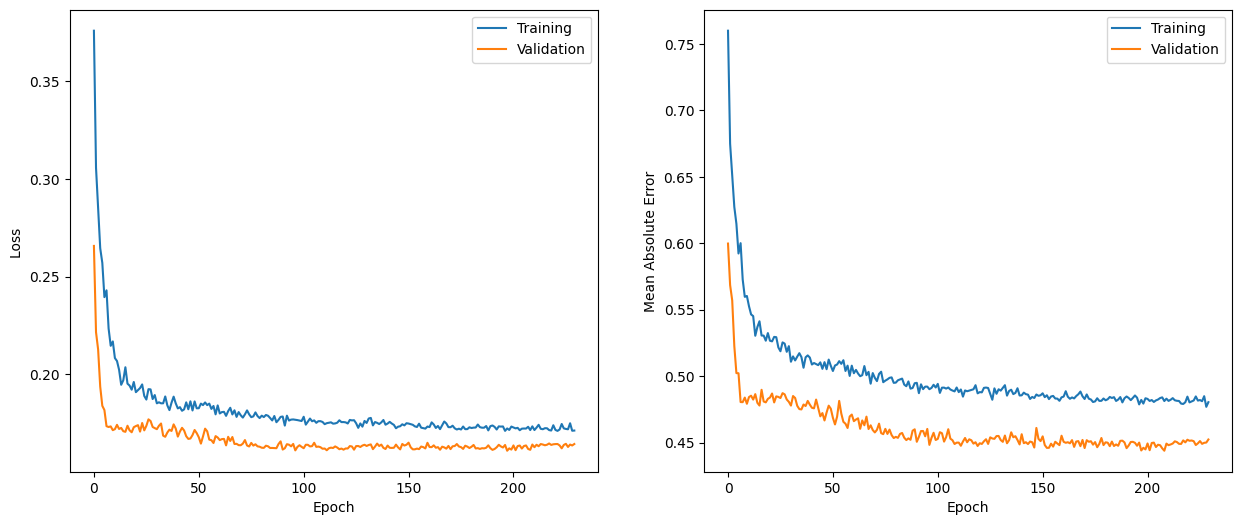

In [97]:
# Invoke the function defined above
plot_learning_curves(history)

Define another function that computes the final MAE  on the training and validation sets.
Notice that while we could just display the last element of the `history` array, it is more precise to re-compute the accuracy with the `evaluate()` method:


In [48]:
# Define a function that computes the final training and validation MAE
# obtained by the trained model
def validation(X_test, Y_test, model):
  val_loss, val_mae = model.evaluate(X_test, Y_test)
  print("\n Val loss:", val_loss)
  print("\n Val MAE:", val_mae)
  return

Invoke the MAE function:

In [98]:
# Invoke the function defined above
validation(X_test, Y_test, model)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1585 - mae: 0.4393 

 Val loss: 0.1644200086593628

 Val MAE: 0.4522966146469116


# 5. Exam Evaluation

As a final delivery for the exam, it is sufficient to fill the cells above correctly, with the *best hyper-parameters* that you could find! You will be evaluated based on how well your model performs in terms of validation MAE, and how well you handled issues such as under/over-fitting.

However, it is more important to verify that you have learned the *process* than the actual numerical results. This means showing that you are able to:
- Diagnose what is wrong with your training
- Implement a corrective measure to fix it
- Explore many reasonable hyper-parameters combinations
- Etc.

Therefore, you are free to **add any number of cells (both markdown and code)** below this one, to show how you proceeded to generate your final results. You can use markdown cells as a sort of "report", describing the things you tried, and the reasons behind your choices. Code cells can contain hyper-parameter exploration loops, etc.

Adding these cells is *not* mandatory, but could help you get a better score.

Please place your additional cells *below* this one, leaving the structure of the notebook intact up to this point!

So, for instance, if you do some hyper-parameters exploration, you can write your exploration code below, but then please copy the hyper-parameters (model architecture, batch size, etc) that give you the best results in the cells of Section 4 above, before delivering the notebook.

---

# **Primo modello base**

In [50]:
model = keras.Sequential([
    Dense(50, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(50, activation='relu'),
    Dense(1, activation='relu')
])
model.summary()

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(
    optimizer=opt,
    loss='mse',
    metrics=['mae'],
)

#history = model.fit(
#    X_train,
#   Y_train,
#    epochs=1000,
#    batch_size=32,
#    validation_data=(X_test, Y_test))

#plot_learning_curves(history)
#validation(X_test, Y_test, model)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 50)             │           550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,151 (12.31 KB)

 Trainable params: 3,151 (12.31 KB)

 Non-trainable params: 0 (0.00 B)

Per prima cosa decido di dimezzare le epoche massime e decido di utilizzare optuna per avere un'idea di quale possa essere la combinazione migliore. Oltre a ciò decido di utilizzare la loss 'huber' in quanto meno sensibile agli outlier, che abbiamo visto essere presenti.

In [51]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.2 MB/s eta 0:00:00


In [57]:
def objective(trial):

    # Hyperparameters to tune
  n_layers = trial.suggest_int('n_layers', 1, 6)
  units = trial.suggest_categorical('units', [16, 32, 50, 64, 128])
  activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
  learning_rate = trial.suggest_loguniform('lr', 0.0001,0.01)

      # Build model
  model = keras.Sequential()
  model.add(Dense(units, activation=activation, input_shape=(X_train.shape[1],)))
  for _ in range(n_layers - 1):
      model.add(Dense(units, activation=activation))
  model.add(Dense(1, activation='relu'))  # Regression output

  model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='huber',
        metrics=['mae'])

      # Train model
  history = model.fit(
          X_train, Y_train,
          validation_data=(X_test, Y_test),
          epochs=100,
          batch_size=32,
          verbose=0)

    # Return validation loss (or mae, depending on your goal)
  val_loss = history.history['val_loss'][-1]
  return val_loss


In [58]:
study = optuna.create_study(direction='minimize')  # for loss
study.optimize(objective, n_trials=20)

[I 2025-07-17 17:01:42,252] A new study created in memory with name: no-name-a61be056-e100-42ed-a5e3-2e6de6773863
[I 2025-07-17 17:02:12,948] Trial 0 finished with value: 0.16791655123233795 and parameters: {'n_layers': 4, 'units': 50, 'activation': 'tanh', 'lr': 0.0002064004056148271}. Best is trial 0 with value: 0.16791655123233795.
[I 2025-07-17 17:02:49,461] Trial 1 finished with value: 0.16605496406555176 and parameters: {'n_layers': 3, 'units': 16, 'activation': 'tanh', 'lr': 0.0015667000507689204}. Best is trial 1 with value: 0.16605496406555176.
[I 2025-07-17 17:03:21,658] Trial 2 finished with value: 0.16580848395824432 and parameters: {'n_layers': 6, 'units': 50, 'activation': 'tanh', 'lr': 0.0020180652466325636}. Best is trial 2 with value: 0.16580848395824432.
[I 2025-07-17 17:03:51,261] Trial 3 finished with value: 0.16689835488796234 and parameters: {'n_layers': 2, 'units': 50, 'activation': 'relu', 'lr': 0.0001240806861741265}. Best is trial 2 with value: 0.1658084839582

In [60]:
print("Best trial:")
print(study.best_trial.params)

Best trial:
{'n_layers': 4, 'units': 50, 'activation': 'tanh', 'lr': 0.00038989574377076803}


In [61]:
opt = keras.optimizers.Adam(learning_rate=0.0004)

model = keras.Sequential([
    Dense(50, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(50, activation='tanh'),
    Dense(50, activation='tanh'),
    Dense(50, activation='tanh'),
    Dense(1, activation='relu')
])

model.compile(
    optimizer=opt,
    loss='huber',
    metrics=['mae'],
)
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_110 (Dense)               │ (None, 50)             │           550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,251 (32.23 KB)

 Trainable params: 8,251 (32.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4119 - mae: 0.7862 - val_loss: 0.3837 - val_mae: 0.7507
Epoch 2/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3933 - mae: 0.7732 - val_loss: 0.3443 - val_mae: 0.7261
Epoch 3/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3052 - mae: 0.6919 - val_loss: 0.2198 - val_mae: 0.5830
Epoch 4/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2207 - mae: 0.5907 - val_loss: 0.1940 - val_mae: 0.5277
Epoch 5/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2013 - mae: 0.5494 - val_loss: 0.1838 - val_mae: 0.5063
Epoch 6/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1934 - mae: 0.5322 - val_loss: 0.1798 - val_mae: 0.4990
Epoch 7/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1895 - mae: 0.5241 - val_loss: 0.1769 - val_mae: 0.4929
Epoch 8/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1865 - mae: 0.5184 - val_loss: 0.1755 - val_mae: 0.4914
Epoch 9/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.18

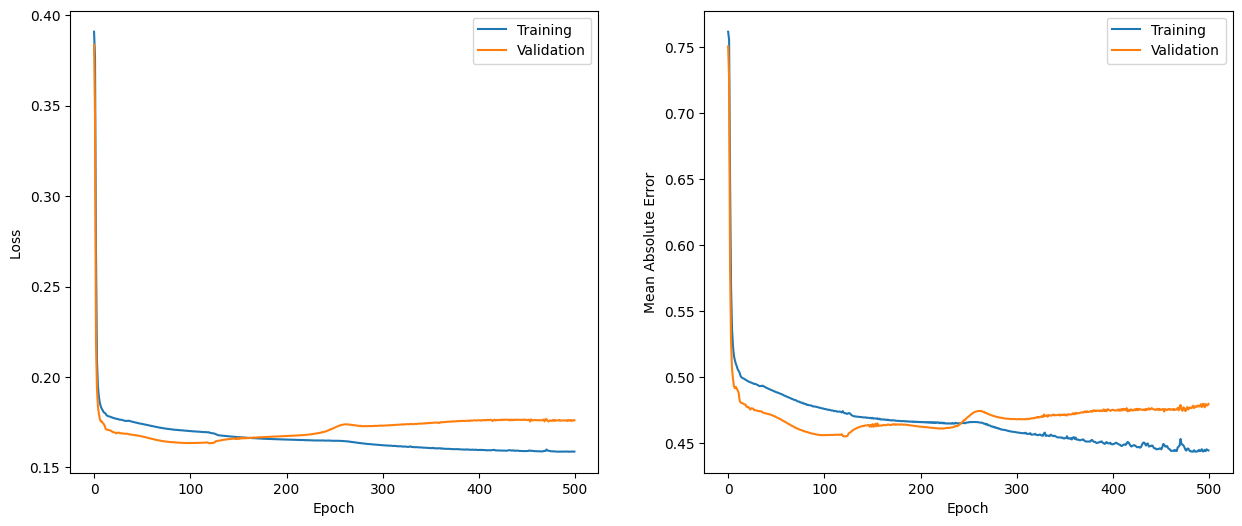

In [62]:
history = model.fit(
    X_train,
    Y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, Y_test),
    verbose = 1
)

plot_learning_curves(history)
validation(X_test, Y_test, model)

visti i risultati ottenuti, provo a fare una prova inserendo un dropout ed aumentando il learning rate a 0.001.

In [72]:
es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    verbose=0,
    mode="min",
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=30,
    min_lr=1e-5,
    verbose=0
)

In [75]:
opt = keras.optimizers.Adam(learning_rate=0.001)

model = keras.Sequential([
    Dense(50, activation='tanh', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dense(1, activation='relu')
])

model.compile(
    optimizer=opt,
    loss='huber',
    metrics=['mae'],
)
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_139 (Dense)               │ (None, 50)             │           550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,801 (42.19 KB)

 Trainable params: 10,801 (42.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.4271 - mae: 0.8123 - val_loss: 0.3709 - val_mae: 0.7219
Epoch 2/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3575 - mae: 0.7375 - val_loss: 0.2295 - val_mae: 0.5773
Epoch 3/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2793 - mae: 0.6497 - val_loss: 0.1935 - val_mae: 0.5219
Epoch 4/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2660 - mae: 0.6299 - val_loss: 0.1939 - val_mae: 0.5286
Epoch 5/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2538 - mae: 0.6169 - val_loss: 0.1857 - val_mae: 0.5113
Epoch 6/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2296 - mae: 0.5819 - val_loss: 0.1801 - val_mae: 0.4990
Epoch 7/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2196 - mae: 0.5728 - val_loss: 0.1754 - val_mae: 0.4883
Epoch 8/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2250 - mae: 0.5756 - val_loss: 0.1722 - val_mae: 0.4803
Epoch 9/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.21

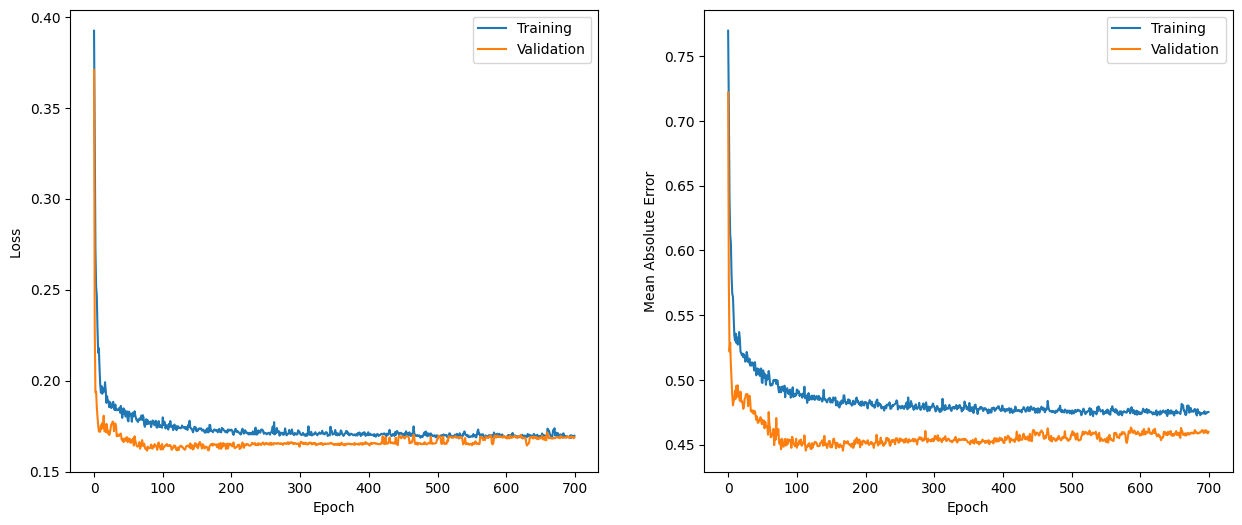

In [76]:
history = model.fit(
    X_train,
    Y_train,
    epochs=700,
    batch_size=32,
    validation_data=(X_test, Y_test),
    #callbacks = [es, reduce_lr],
    verbose = 1
)

plot_learning_curves(history)
validation(X_test, Y_test, model)

Come possiamo vedere mentre la training loss si appiattisce, la test loss, sia per 'huber' che per 'mae' incrementa, per questo motivo, dato che l'incremento della test loss ci indica un possibile overfitting, ho deciso di "tagliare" intorno all'epoca 230/240.

In [84]:
opt = keras.optimizers.Adam(learning_rate=0.001)

model = keras.Sequential([
    Dense(50, activation='tanh', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dropout(0.3),
    Dense(50, activation='tanh'),
    Dense(1, activation='relu')
])

model.compile(
    optimizer=opt,
    loss='huber',
    metrics=['mae'],
)
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_157 (Dense)               │ (None, 50)             │           550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,801 (42.19 KB)

 Trainable params: 10,801 (42.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4415 - mae: 0.8283 - val_loss: 0.3712 - val_mae: 0.7270
Epoch 2/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3587 - mae: 0.7398 - val_loss: 0.2343 - val_mae: 0.5827
Epoch 3/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2876 - mae: 0.6565 - val_loss: 0.1901 - val_mae: 0.5154
Epoch 4/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2506 - mae: 0.6121 - val_loss: 0.1804 - val_mae: 0.4991
Epoch 5/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2507 - mae: 0.6136 - val_loss: 0.1835 - val_mae: 0.4982
Epoch 6/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2351 - mae: 0.5893 - val_loss: 0.1810 - val_mae: 0.4988
Epoch 7/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2401 - mae: 0.5936 - val_loss: 0.1762 - val_mae: 0.4908
Epoch 8/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2385 - mae: 0.5933 - val_loss: 0.1715 - val_mae: 0.4806
Epoch 9/230
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0

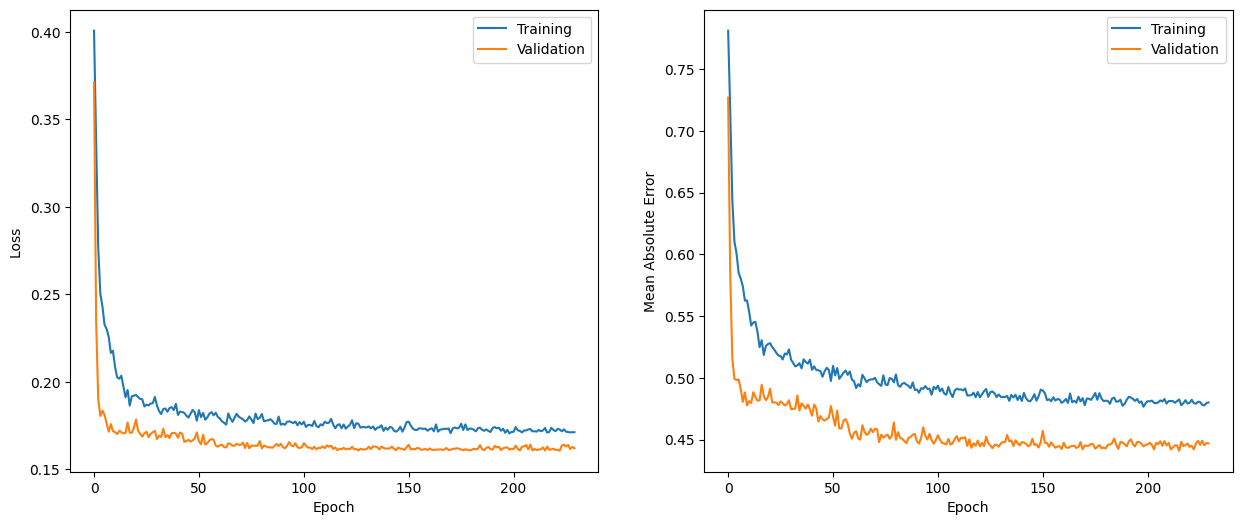

In [85]:
history = model.fit(
    X_train,
    Y_train,
    epochs=230,
    batch_size=32,
    validation_data=(X_test, Y_test),
    #callbacks = [es, reduce_lr],
    verbose = 1
)

plot_learning_curves(history)
validation(X_test, Y_test, model)